In [21]:
!uv pip install -r requirements.txt 

Audited 126 packages in 75ms


In [22]:
from typing import Annotated, List
import operator
from IPython.display import Markdown
from langgraph.types import Send
from pydantic import BaseModel, Field
from typing_extensions import TypedDict
from langchain.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from IPython.display import Image, display
from langchain.tools import tool
from langchain.messages import AnyMessage


In [23]:

llm = ChatOpenAI(
    model="gpt-5",
    api_key="ahhh",
    base_url="http://127.0.0.1:1234/v1",
)

# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a / b

tools = [multiply, add, divide]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )


# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

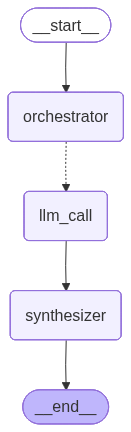

InvalidUpdateError: At key 'llm_calls': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://docs.langchain.com/oss/python/langgraph/errors/INVALID_CONCURRENT_GRAPH_UPDATE

In [24]:


# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report


# Worker state
class WorkerState(TypedDict):
    section: Section 
    completed_sections: Annotated[list[str], operator.add]
    messages: Annotated[list[AnyMessage], operator.add]
    llm_calls: Annotated[int, add]



# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report"),
            HumanMessage(
                content=f"Create a detailed plan for a report on the topic: {state['topic']}. "
                "Break down the report into sections with a name and brief description for each section.")
        ]
    )

    return {"sections": report_sections.sections}

# Orca with Tula hybrid worker
def llm_call(state: WorkerState):
    """Worker writes a report section, optionally using tools if needed."""

    # Define the system prompt: hybrid of Orca (report writing) and Tula (tool use)
    system_prompt = (
        "You are a helpful assistant tasked with writing a report section based on the provided name and description. "
        "You may use tools if the section requires calculations, data lookup, or other external operations. "
        "Otherwise, write the section directly in markdown. Do not include any preamble or explanations — "
        "only output the final section content or a tool call if needed."
    )

    # Prepare messages
    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(
            content=f"Section name: {state['section'].name}\nDescription: {state['section'].description}"
        ),
    ]

    # Invoke the model with tools (like Tula)
    result = llm_with_tools.invoke(messages)

    # Extract the content and check if it's a tool call
    if hasattr(result, 'tool_calls') and result.tool_calls:
        # Tool was called — we'll handle the tool execution in a separate step (e.g., in a graph node)
        # For now, just record the tool call and increment counter
        return {
            "messages": messages + [result],  # Keep message history
            "llm_calls": state.get('llm_calls', 0) + 1,
            "pending_tool_calls": result.tool_calls,  # Pass to tool executor node
            "completed_sections": []  # No section written yet — waiting for tool result
        }
    else:
        # LLM generated a direct response — assume it's the section content
        section_content = result.content

        return {
            "messages": messages + [result],  # Log the interaction
            "llm_calls": state.get('llm_calls', 0) + 1,
            "completed_sections": [section_content],  # Success! Section written
            "pending_tool_calls": []  # No pending tools
        }



def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]

def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


def should_continue(state: ) -> Literal["tool_node", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]

    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "tool_node"

    # Otherwise, we stop (reply to the user)
    return END

# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
# orchestrator_worker_builder.add_node("llm_call1", llm_call1)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call",]
)

orchestrator_worker_builder.add_edge("llm_call", "synthesizer")

orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

# Invoke
state = orchestrator_worker.invoke({"topic": "What is two plus two?"})

Markdown(state["final_report"])